In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

#### this stage will use axl.tournament function to train DQN play against multiple strategies
to see if it converges to TFT under more complex environment

## Set up environment & DQN

In [3]:
# import my modified tournament
# which ignores the interaction in last turn
from axl_utils.tournament import Tournament

In [4]:
tournament = Tournament([axl.Defector(), axl.Cooperator()], game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 78.13it/s]


In [5]:
# example tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

# CC_to_C rate means the probability of the strategy to cooperaate following a mutual cooperation (C,C)

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Defector,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0,0.00,0,0
1,1,Cooperator,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0,1.00,0,0


In [6]:
# this is the environment we'll be using

# I'm trying to encourage provocative defection     (against cooperative strategies)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)

# documentation of the strategies can be found here
# https://axelrod.readthedocs.io/en/stable/_modules/index.html

cooperative = (axl.Random(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())

players = [*cooperative, *provocative, *retaliative]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

summary = results.summarise()
pd.DataFrame(map(list, summary), columns=headers)

# again proves the robustness of TFT

Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 76.69it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.72,0.82,0.00,1.00,0.69,0.13,0.12,0.06,1.00,0.00,1.00,0.00
1,1,Punisher,2.67,0.58,3.00,1.00,0.55,0.03,0.14,0.28,1.00,0.00,0.01,0.00
2,2,Grudger,2.55,0.54,3.00,1.00,0.51,0.03,0.14,0.32,1.00,0.00,0.00,0.00
3,3,Remorseful Prober: 0.1,2.55,0.64,2.00,1.00,0.47,0.17,0.18,0.18,0.90,0.00,0.93,0.46
4,4,Tit For 2 Tats,2.35,0.84,0.00,1.00,0.68,0.16,0.03,0.13,1.00,0.76,1.00,0.00
5,5,Prober 4,2.11,0.50,3.00,1.00,0.21,0.29,0.25,0.25,0.34,0.35,0.76,0.71
6,6,Prober,1.99,0.41,1.00,0.00,0.25,0.16,0.17,0.42,0.89,0.47,0.86,0.14
7,7,Random: 0.5,1.99,0.48,3.00,0.41,0.20,0.28,0.21,0.31,0.52,0.45,0.47,0.51


In [7]:
# DQN as usual
# + a bit more complex architecture
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 7e-6, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-2), "loss_fn":"mse"}

In [8]:
from random import shuffle     

# function to match the DQN against a list of opponents
def train_against(player, opponents, iterations=40):
    for _  in range(iterations):
        shuffle(opponents)
        for opponent in opponents:
            play(player, opponent, show=False)

In [9]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 8(# of opponents) * 40(iterations)

6720

# Training loop
**takes ~ 1 hours to run**

In [10]:
# Following is just a example
# Running in terminal (with Stage_2.py) is faster than in jupyter
if False:

    ls = []
    for i in range(60):
        
        print(f"-- Iter{i} --")
        
        start = time()
        p1.train(200, param)
        train_against(p1, players)
        print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')

        if i % 2 == 0:
            with p1:
                p1.network.verbosity = False
                tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
                results = tournament.play()
                summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
                ls.append(summary)

            print(summary.loc['DQN', ['Rank', 'Median_score']])

            with open('data/s2/tn_results.pkl', "wb") as file:
                dill.dump(ls, file)

            with open(f'data/s2/p1_{i}.pkl', "wb") as file:
                dill.dump(p1, file)

# Results

In [12]:
with open("data/s2/backup/tn_results.pkl", "rb") as file:
    ls = dill.load(file)
    
with open("data/s2/backup/p1_58.pkl", "rb") as file:
    p1 = dill.load(file)

In [13]:
pd.DataFrame([l.loc['DQN'] for l in ls], index=range(30))

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,8.00,1.77,0.06,6.00,0.00,0.00,0.06,0.21,0.73,0.00,0.00,0.10,0.09
1,6.00,2.14,0.46,5.50,0.00,0.09,0.36,0.33,0.22,0.34,0.28,0.60,0.87
2,4.00,2.28,0.55,4.00,1.00,0.21,0.34,0.30,0.15,0.43,0.29,0.91,0.76
3,6.00,2.07,0.45,4.00,0.00,0.11,0.35,0.30,0.24,0.52,0.29,0.69,0.80
4,4.00,2.27,0.48,4.00,1.00,0.20,0.28,0.29,0.23,0.29,0.24,0.85,0.57
5,4.00,2.36,0.57,5.00,1.00,0.30,0.27,0.25,0.17,0.67,0.43,0.67,0.70
6,4.00,2.39,0.58,4.00,1.00,0.31,0.27,0.26,0.16,0.71,0.24,0.82,0.52
7,4.00,2.41,0.58,5.00,1.00,0.34,0.24,0.24,0.18,0.66,0.49,0.68,0.59
8,2.00,2.58,0.59,5.00,1.00,0.39,0.20,0.25,0.16,0.77,0.26,0.78,0.54
9,2.00,2.53,0.62,5.00,1.00,0.44,0.18,0.21,0.17,0.78,0.50,0.72,0.50


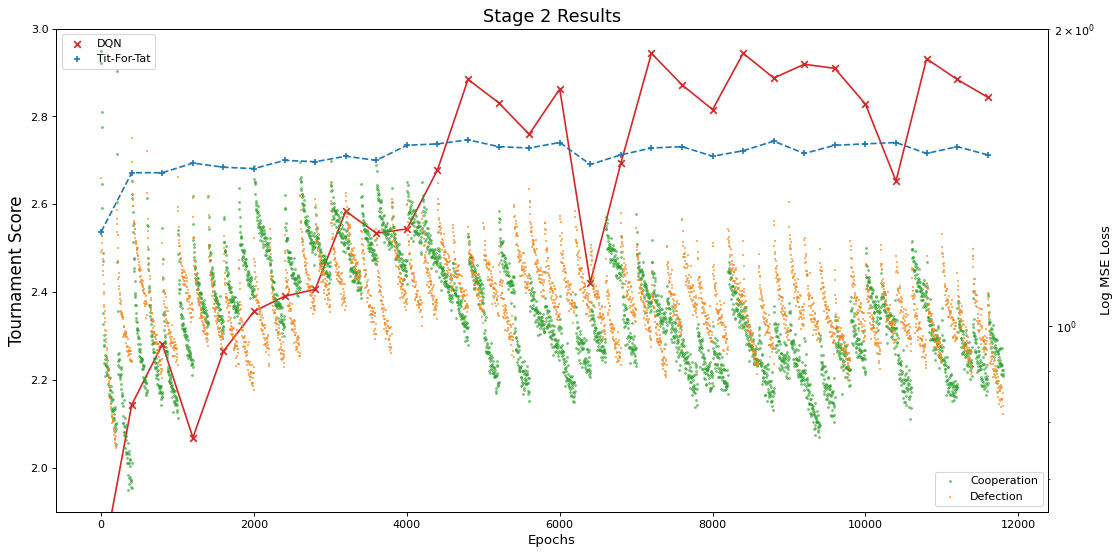

In [14]:
# visualizing the results

# we did collected more data than those demonstrated below
# but since our DQN did not converge to TFT I don't think the C_rate(s) are of any use...

# extracting score from DQN & TFT
d_score = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
t_score = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

fig, ax1 = plt.subplots(figsize=(16, 8), dpi=80)
ax2 = ax1.twinx()

# score
x_axis = range(0, 30*2*200,2*200)
ax1.scatter(x_axis, d_score, c='tab:red', marker='x', label='DQN')
ax1.scatter(x_axis, t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
ax1.plot(x_axis, d_score, c='tab:red')
ax1.plot(x_axis, t_score, '--', c='tab:blue')
ax1.set_ylim([1.9, 3.0])

# loss
ax2.scatter(*zip(*[(i[0], i[1][0]) for i in p1.network.loss_ls[::3]]), c='tab:green', marker='x', label='Cooperation', alpha=.6, s=3)
ax2.scatter(*zip(*[(i[0], i[1][1]) for i in p1.network.loss_ls[::3]]), c='tab:orange', marker='+', label='Defection', alpha=.6, s=3)
#ax2.set_ylim([0.0, 3.0])
ax2.set_yscale('log')

ax1.legend(loc='upper left')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Tournament Score', fontsize=15)
ax1.set_title('Stage 2 Results', fontsize=16)

ax2.legend(loc='lower right')
ax2.set_ylabel('Log MSE Loss', fontsize=12)


plt.show()

In [22]:
ls[-3].loc['DQN']
# from the analysis we can already conclude it did not reach TFT
# but lets see how it will perform in practice

Rank                 0.00
Median_score         2.93
Cooperation_rating   0.74
Wins                 7.00
Initial_C_rate       1.00
CC_rate              0.68
CD_rate              0.06
DC_rate              0.15
DD_rate              0.11
CC_to_C_rate         0.89
CD_to_C_rate         0.41
DC_to_C_rate         0.41
DD_to_C_rate         0.30
Name: DQN, dtype: float64

In [23]:
with open("data/s2/backup/p1_54.pkl", "rb") as file:
    p1 = dill.load(file)
    
# testing DQN
p1.network.greedy = 0
p1.network.verbosity = False

# against 'nice' strategies
for p in [axl.TitFor2Tats(), *retaliative]:
    print(p)
    play(p1, p)
    print('\n')

# learnt to build up mutual cooperation with these strategies 
# + our favorite backstab!
# I have to admit this's a bit cheating since other strategies don't have access to game length
# probably DQN will not be able to beat Tit-For-Tat in the tournaments if it can't backstab

Tit For 2 Tats
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


Tit For Tat
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


Grudger
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


Punisher
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57




In [28]:
play(p1, axl.Random(0.5));
# has the ability to identify Random then defect in most turns

[(0, 5), (1, 1), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (3, 3), (1, 1), (0, 5), (5, 0), (3, 3), (5, 0), (3, 3), (1, 1), (5, 0), (3, 3), (5, 0), (3, 3), (5, 0)]
Player 1 score = 60
Player 2 score = 30


In [29]:
for p in provocative[:2]:
    print(p)
    play(p1, p)
    print('\n')
    
# both Prober & Prober 4 is hardcoded
# so our DQN rote learnt the pattern and the best reaction to them
# makes it perform better than TFT in *this* case

print('---Compare to TFT---')
for p in provocative[:2]:
    print(p)
    play(axl.TitForTat(), p)
    print('\n')

Prober
[(0, 5), (5, 0), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 60
Player 2 score = 55


Prober 4
[(3, 3), (3, 3), (0, 5), (5, 0), (1, 1), (1, 1), (1, 1), (5, 0), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (5, 0), (1, 1), (5, 0), (1, 1), (1, 1), (5, 0), (1, 1)]
Player 1 score = 55
Player 2 score = 20


---Compare to TFT---
Prober
[(0, 5), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 59
Player 2 score = 59


Prober 4
[(3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (1, 1), (1, 1), (5, 0), (3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (3, 3), (0, 5), (5, 0), (0, 5), (1, 1), (5, 0), (0, 5)]
Player 1 score = 45
Player 2 score = 50




In [30]:
# but, rote learning won't genealize well
# below are strategies not occured in the tournament

# also evidence that it hasn't converge to TFT
# quite close to it though

print('Defector')
play(p1, axl.Defector());

print('\nAlternator')
play(p1, axl.Alternator());


print('\n--TFT--\n')
play(axl.TitForTat(), axl.Defector());
play(axl.TitForTat(), axl.Alternator());

Defector
[(0, 5), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 5), (1, 1), (1, 1), (0, 5), (1, 1), (1, 1), (0, 5), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 16
Player 2 score = 36

Alternator
[(3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (1, 1), (5, 0), (0, 5), (3, 3), (1, 1), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (1, 1), (3, 3), (1, 1)]
Player 1 score = 46
Player 2 score = 46

--TFT--

[(0, 5), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 19
Player 2 score = 24
[(3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5)]
Player 1 score = 48
Player 2 score = 53


In [31]:
# RemorsefulProber defects by chance
# we can use this to investigate DQN's retaliation
l = [play(p1, axl.RemorsefulProber(0.1)) for _ in '123454321'][-1]

# it is capable of retaliation in the first few turns (probably trained by Prober)
# but not so good in the later turns (e.g. see 5th last turn)

[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 59
Player 2 score = 59
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (3, 3), (3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (5, 0)]
Player 1 score = 55
Player 2 score = 60
[(3, 3), (3, 3), (0, 5), (5, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 5), (3, 3), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0), (1, 1)]
Player 1 score = 37
Player 2 score = 42
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (3, 3), (3, 3), (5, 0)]
Player 1 score = 56
Player 2 score = 61
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score 

In [ ]:
# => continue exploration on stage 3